In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
import warnings
from operator import attrgetter
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./data_app.csv', sep=';')
df1 = pd.read_csv('./ch_cost.csv', sep=';')
data = pd.merge(df, df1, on="channel")

In [3]:
data.rev = [float(i.replace(',', '.')) for i in data.rev]

In [4]:
data.describe()

,au,rev,cost_per_user
count,275.000000,2.750000e+02,275.000000
mean,51675.141818,2.979348e+06,50.800000
std,61497.899636,3.451701e+06,13.099005
min,76.000000,3.408600e+04,32.000000
25%,8967.000000,6.744088e+05,45.000000
50%,45322.000000,2.668983e+06,50.000000
75%,65488.500000,3.613845e+06,55.000000
max,409256.000000,2.443152e+07,72.000000


### Задание 1. 

Нужно произвести оценку каналов привлечения **с точки зрения качества привлекаемых пользователей**. 
Какие метрики Вы бы использовали? 
Какой канал привлечения следует развивать в первую очередь на ваш взгляд?


#### Кто такой хороший пользователь? Тот, кто долго остается в продукте и платит деньги

В разрезе каналов привлечения посмотрим на ретеншн пользователей по когортам. Посчитаем их LTV.

In [5]:
def create_m(value='au', flg='retention'):
    data.fst_mnth = pd.to_datetime(data.fst_mnth, format="%d.%m.%Y")
    data.business_mnth = pd.to_datetime(data.business_mnth, format="%d.%m.%Y")
    cohort_pivots = []
    cohort_sizes = []
    retention_matrixs = []
    for i in range(1, 6):
        dh = data[data.channel == f'Ch_{i}']
        dh['nb_months'] = ((dh.business_mnth - dh.fst_mnth)/np.timedelta64(1, 'M'))
        dh.nb_months = dh.nb_months.round()
        dh = dh.sort_values(by=['fst_mnth', 'nb_months'], ascending = False, inplace = False)
        dh['fst_mnth'] = dh['fst_mnth'].dt.strftime('%Y-%m-%d')

        cohort_pivot = dh.pivot_table(index='fst_mnth', columns = 'nb_months', values = value)
        cohort_size = cohort_pivot.iloc[:,0]
        
        if flg == 'ltv':
            cohort_pivot = dh.pivot_table(index='fst_mnth', columns = 'nb_months', values = 'au')
            cohort_size = cohort_pivot.iloc[:,0]
            
            cohort_pivot = dh.pivot_table(index='fst_mnth', columns = 'nb_months', values = value)
            cohort_pivot = cohort_pivot.cumsum(axis=1)
            
        retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

        cohort_pivots.append(cohort_pivot)
        cohort_sizes.append(cohort_size)
        retention_matrixs.append(retention_matrix)
    return retention_matrixs, cohort_sizes

In [6]:
def show_m(retention_matrixs, cohort_sizes, flg='retention'):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(5, 2, figsize=(16, 16), sharey=True, gridspec_kw={'width_ratios': [1, 15]})

        for i in range(0, 5):
            
            if flg == 'ltv':
                fmt_m = '.2f'
                title = f'Monthly Cohorts: User {flg} in Ch_{i+1} with CAC {df1[df1.channel == f"Ch_{i+1}"].cost_per_user.values[0]}'
            else:
                fmt_m = '.0%'
                title = f'Monthly Cohorts: User {flg} in Ch_{i+1}'
            # retention matrix
            sns.heatmap(retention_matrixs[i], 
                        mask=retention_matrixs[i].isnull(), 
                        annot=True, 
                        fmt=fmt_m, 
                        cmap='RdYlGn', 
                        ax=ax[i, 1])
            ax[i, 1].set_title(title, fontsize=16)
            ax[i, 1].set(xlabel='# of periods',
                      ylabel='')

            # cohort size
            cohort_size_df = pd.DataFrame(cohort_sizes[i]).rename(columns={0: 'cohort_size'})
            white_cmap = mcolors.ListedColormap(['white'])
            sns.heatmap(cohort_size_df, 
                        annot=True, 
                        cbar=False, 
                        fmt='g', 
                        cmap=white_cmap, 
                        ax=ax[i, 0])

        fig.tight_layout()

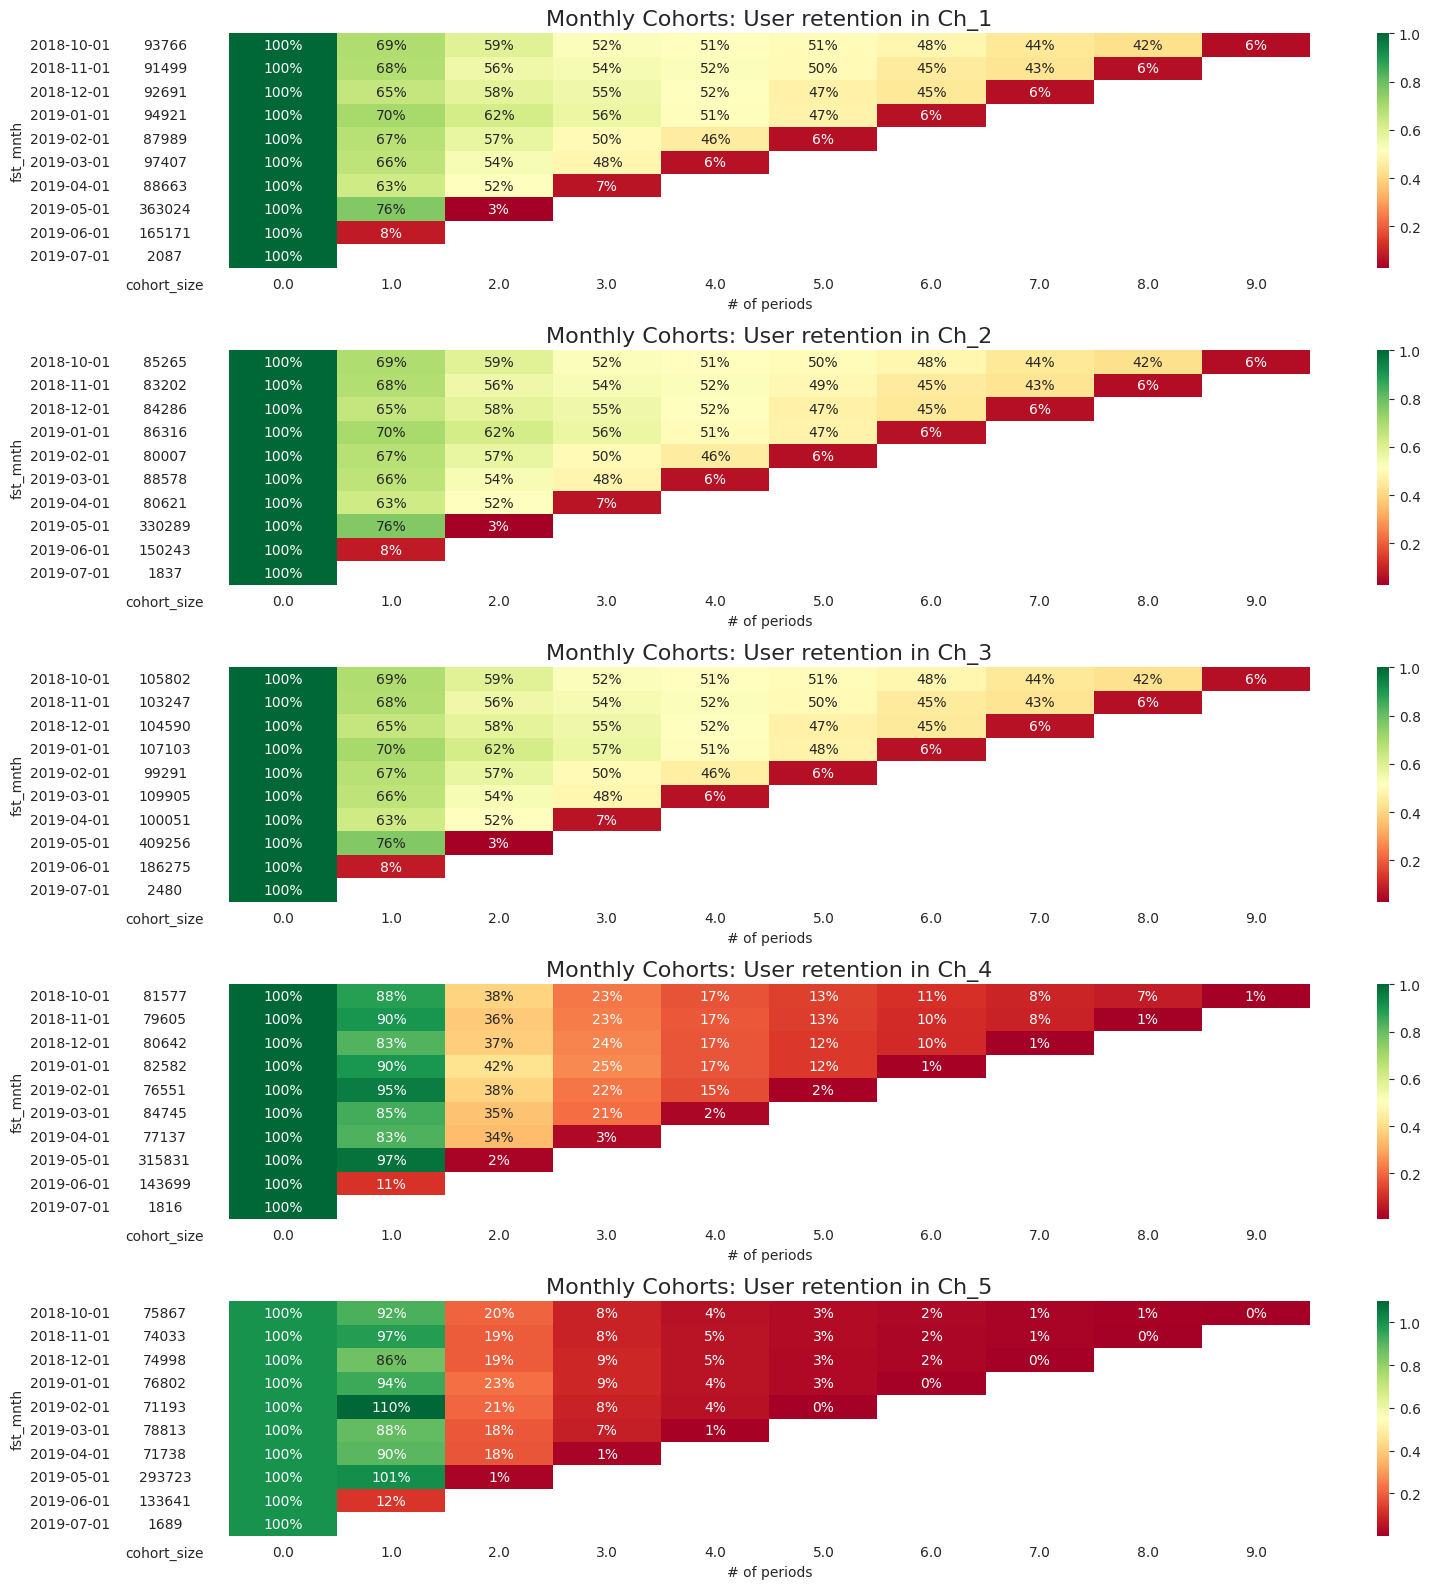

In [7]:
r, c = create_m()
show_m(r, c)

#### Выводы про ретеншн

В каналах 1-3 осталось 6% пользователей от тех, кто пришел 9 месяцев назад. В канале 4 – 1%, в канале 5 – 0%. Если брать периоды меньше, то каналы 4 и 5 показывают результаты по удержанию пользователей хуже. Однако в этих каналах удержание после первого месяца лучше, чем в трех остальных. 

Таким образом, вовлеченность после первого месяца у пользователей, которые пришли через каналы 4, 5 лучше, однако, если рассматривать период в 5 месяцев, то каналы 1-3 приводят более качественных пользователей.

Если нет какой-то ошибки в данных, потому что в канале 5 у двух когорт через месяц пользователей стало больше, чем пришло.

### Посмотрим на поканальных доход

Посчитаем LTV. Посмотрим, сколько денег в разных когортах в разных каналах приносит один пользователь за все время жизни в продукте. 

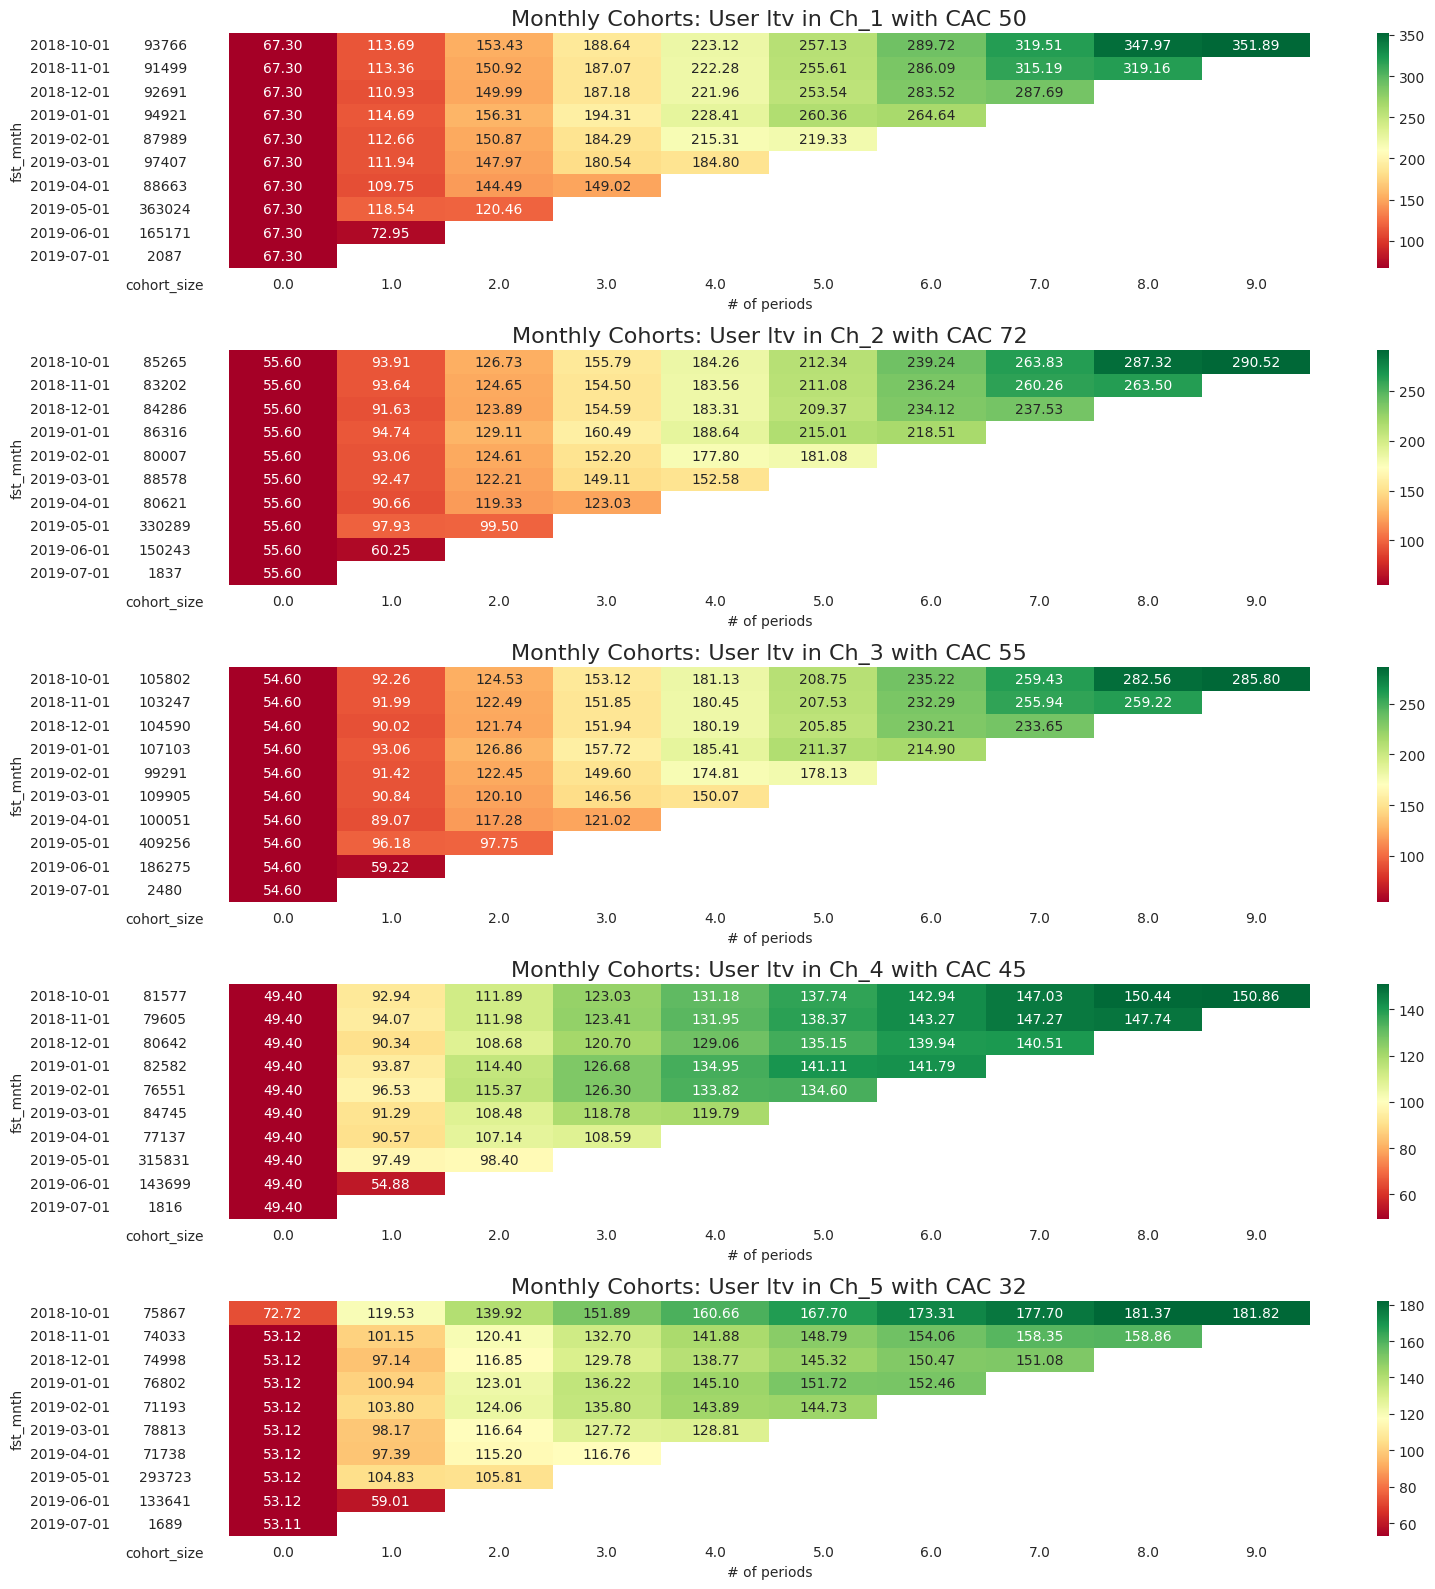

In [8]:
r,c = create_m(value='rev', flg='ltv')
show_m(r, c, flg='ltv')

#### Выводы про LTV

За 9 месяцев в 1ом канале пользователь приносит больше всего денег. 2ой и 3ий каналы имеют примерно равные значения. Далее 5ый и меньше всего 4ый. Через 5ть месяцев ранжирование каналов сохраняется.  

Однако через месяц высокие показатели по по-прежнему у 1ого канала, но и у 5ого.

Для каждого канала виден СAC, LTV должен быть выше стоимости привлечения клиента. Если компания тратит больше на привлечение покупателя, чем получает от него денег, то она работает в убыток. Видно, что каналы 1 - 3 окупаются только через месяц.

Таким образом, лучшие показатели LTV в долгосрочном периоде у канала 1.

### Выводы к 1 заданию 

В долгосрочной перспективе лидирует канал 1. У него один из самых высоких ретеншенов, пользователи, пришедшие из этого канала, хорошо платят на протяжение все своей жизни в продукте. 
Далее идут канала 2 и 3. Примерно с одинаковым LTV и ретеншеном.

В канале 4 ретеншн лучше, чем в 5, но в канале 5 за время своей жизни в продукте пользователь платит больше. 

Я бы рекомендовала следующую приоритетность каналов для развития продукта:
Ch_1
Ch_2
Ch_3
Ch_5
Ch_4, то есть в первую очередь Ch_1

### Задание 2

#### На основании приложенных данных, оцените общую динамику развития продукта.


 Посмотрим на количество активных пользователей по месяцам. Не учитываем последний месяц 2019-07, тк он неполный.

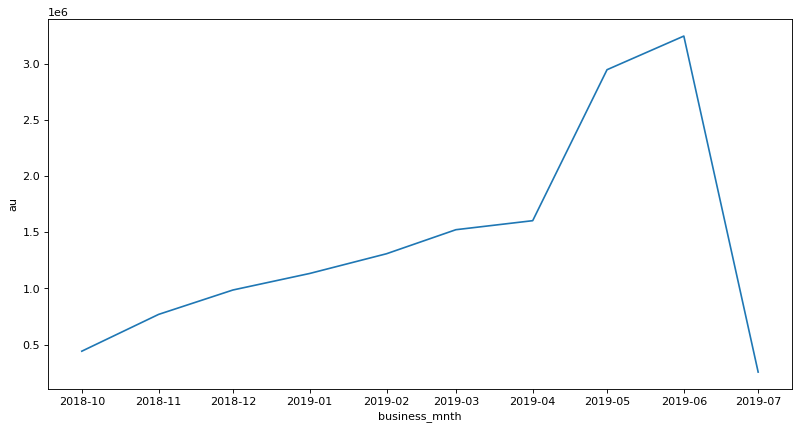

In [9]:
figure(figsize=(12, 6), dpi=80)

sns.lineplot(x = "business_mnth", y = "au", sort=False, data = data.groupby(['business_mnth']).au.sum().reset_index(), ci=None)
plt.show()

**Выводы**: наблюдается рост активных пользователеq продукта. 2019-04 вероятно была какая-то удачная акция, в результате чего получился сильный прирост пользователей. У этого события даже не временный эффект, так как в следующем месяце 2019-06 количество активных пользователей продолжило расти.

##### Посмотрим на поведение новичков

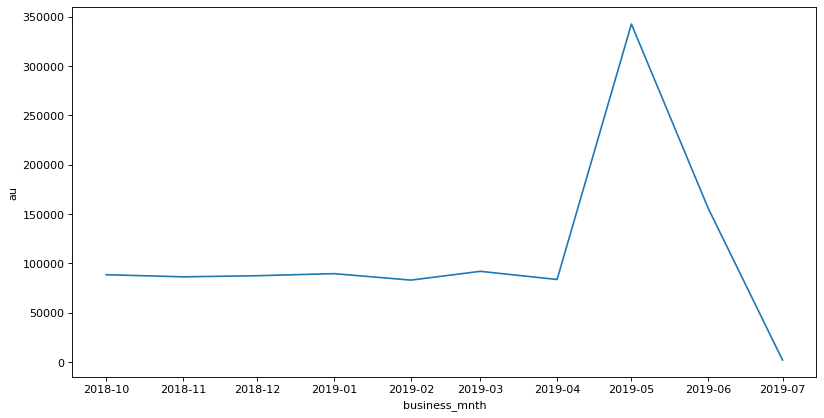

In [10]:
figure(figsize=(12, 6), dpi=80)
sns.lineplot(x = "business_mnth", y = "au", sort=False, data = data[data.fst_mnth == data.business_mnth], ci=None)
plt.show()

**Выводы**: 2019-05 сильный прирост новых пользователей, что может быть вызвано удачным предложением, либо какими-то внешними обстоятельствами, так как далее 2019-06 количество новичков уменьшилось (но все равно больше, чем было до 2019-05).

##### Посмотрим на поведение старых пользователей

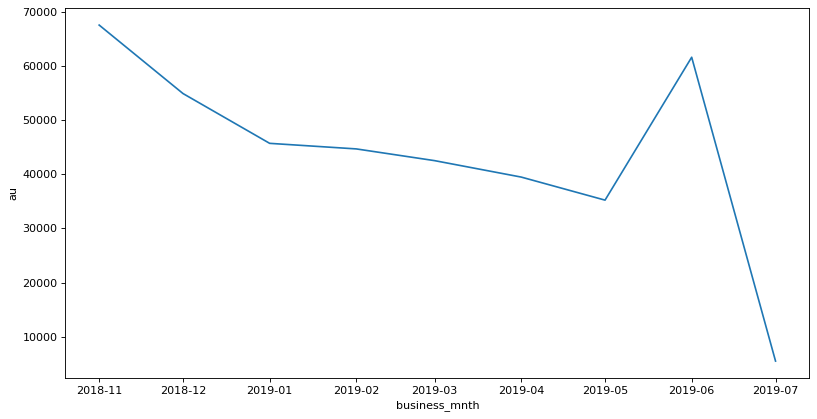

In [11]:
figure(figsize=(12, 6), dpi=80)
sns.lineplot(x = "business_mnth", y = "au", data = data[data.fst_mnth != data.business_mnth], ci=None)
plt.show()

**Выводы**: здесь видно, что привлеченные 2019-05 были активны еще месяц после привлечения, то есть акция по привлечению новых пользователей была весьма удачной

**Выводы про динамику приложения по количеству новых пользователей**: наблюдается рост. В последние месяцы были использованы эффективные способы привлечения пользователей. Динамика положительная и многообещающая. 

#### Посчитаем теперь доход 

Доход по месяцам имеет возрастающий тренд:

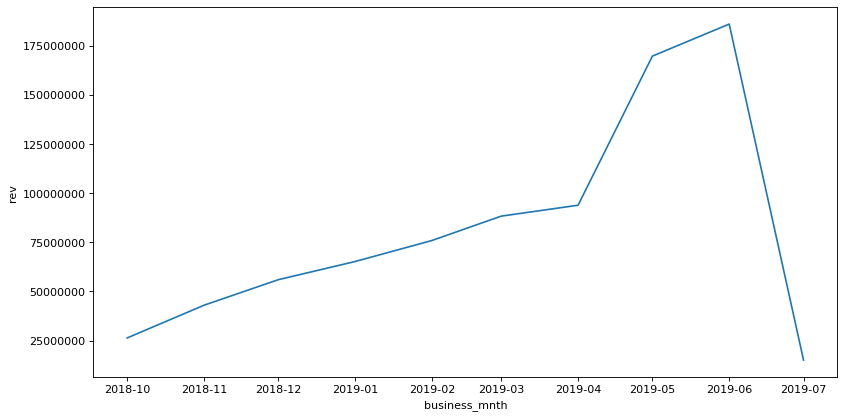

In [12]:
figure(figsize=(12, 6), dpi=80)
sns.lineplot(x = "business_mnth", y = "rev",  sort=False, data = data.groupby(['business_mnth']).rev.sum().reset_index())
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Доход от новичков:

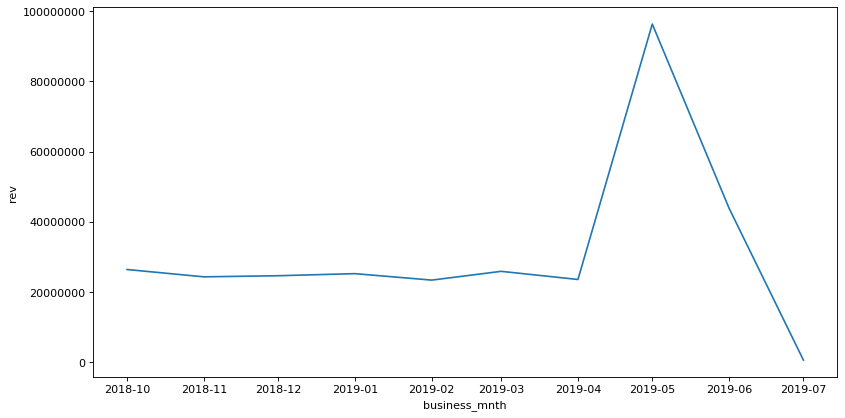

In [13]:
figure(figsize=(12, 6), dpi=80)
sns.lineplot(x = "business_mnth", y = "rev", sort=False, data = data[data.fst_mnth == data.business_mnth].groupby(['business_mnth']).rev.sum().reset_index(), ci=None)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

График подтверждает скачок по количеству новичков

Посмотрим на доход от старичков:

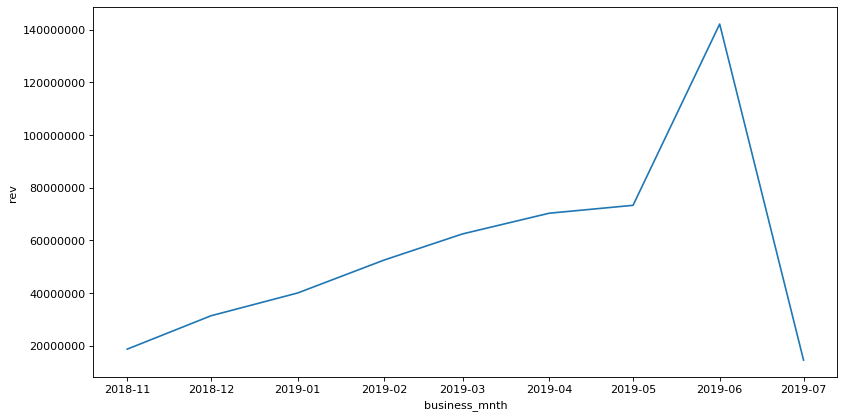

In [14]:
figure(figsize=(12, 6), dpi=80)
sns.lineplot(x = "business_mnth", y = "rev",sort=False, data = data[data.fst_mnth != data.business_mnth].groupby(['business_mnth']).rev.sum().reset_index(), ci=None)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

**Вывод**: количество постоянных пользователей растет, как и доход от них

**Вывод по доходу**: доход до вычета затрат от месяца к месяцу растет

**Выводы про динамику приложения по доходу**: доход растет! Остается надеяться, что расходов меньше, чем доходов.

#### Посмотрим на окупаемость инвестиций, то есть через сколько продукт возвращает деньги от привлечения пользователей.

А для этого почитаем ROI:

In [15]:
data['invest'] = data['au'] * data['cost_per_user']

In [16]:
revenue = pd.merge(data[data.fst_mnth == data.business_mnth].groupby(['fst_mnth']).invest.sum().reset_index(), data.groupby(['fst_mnth'])['rev'].sum().reset_index(), on=['fst_mnth'])
revenue['clean'] = revenue['rev'] - revenue['invest']
revenue['roi'] = 100.0 * (revenue['rev'] - revenue['invest']) / revenue['invest'] 
revenue = revenue.round()

In [17]:
revenue.pivot_table(columns = 'fst_mnth', values ='roi').round()

fst_mnth,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01
roi,402.0,357.0,317.0,293.0,238.0,189.0,142.0,103.0,20.0,10.0


**Выводы**: затраты на привлечения пользователей начинают окупаться примерно через 2 месяца, а за 9 месяцев инвестиции окупились на 400%. 

Посмотрим на динамику среднего дохода от старичков по месяцам:

In [43]:
din =  pd.merge(data[data.fst_mnth != data.business_mnth].groupby('business_mnth').au.sum().reset_index(), data[data.fst_mnth != data.business_mnth].groupby('business_mnth').rev.sum().reset_index(), on=['business_mnth'])

In [44]:
din['res'] =  1.0 * din['rev']/din['au']

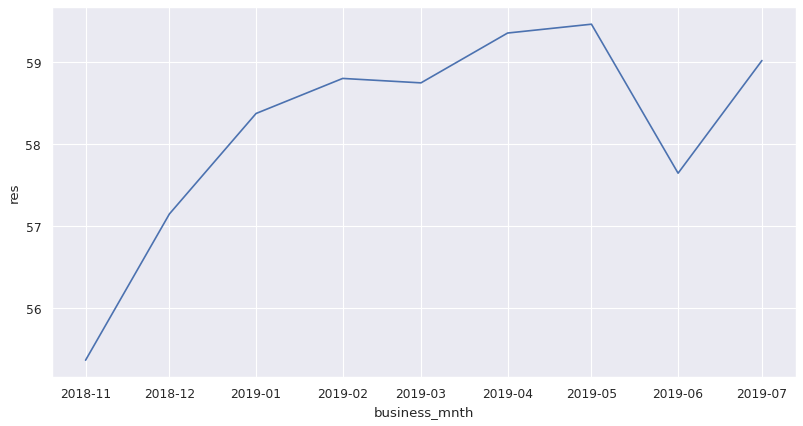

In [45]:
figure(figsize=(12, 6), dpi=80)
sns.lineplot(x = "business_mnth", y = "res", data = din, ci=None)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

**Выводы**: от месяца к месяцу доход на одного человека от постоянных пользователей растет, что говорит о положительной динамике развития продукта. 2019-05 привлекли много новых "холодных" или нецелевых пользователей, поэтому 2019-06 из-за них есть просадка по среднему доходу на человека.

### Выводы ко 2му заданию 

В общем динамика развития продукта положительная, растет как количество новых пользователй и доход от них, так и средний доход от постоянных пользователей.

### Дополнительно

Посмотрим на затраты по каналам: 

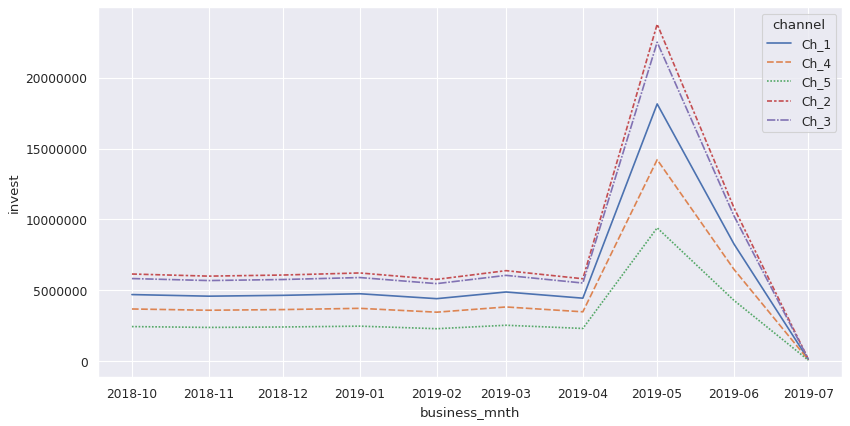

In [18]:
sns.set_theme(style="darkgrid")
figure(figsize=(12, 6), dpi=80)
sns.lineplot(x = "business_mnth", y = "invest", hue='channel' , style="channel", sort=False, data = data[data.fst_mnth == data.business_mnth], ci=None)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Каналы 4 и 5 были определены как не очень перспективные, но и денег на них было потрачено меньше всего. Канал привлечения 1 еще хорош тем, что значительно дешевле чем 2 и 3. 